### Week 2: Neural network in AWS SageMaker

- Today we are going to use AWS SageMaker to build, train and deploy a MLP. 
- Our data and goals are the same as Week 3- we will use the Fashion MNIST data and our goal will be to construct a simple MLP to classify the types of clothing. 

Our tasks are:
1. Understand the structure of AWS-SageMaker.

2. How to create a instance on AWS-SageMaker.

3. Requesting instances with larger capacity - contact AWS support team 

3. Demonstrate how to build, train, deploy and evaluate a VNN on AWS. 

4. Remember to **stop instance and DELETE endpoint** when they finish tasks otherwise AWS will keep charging. It can be very expensive.


### Build, train and deploy a NN model in AWS SageMaker
Data
- MNIST fashion data contains 60,000 small square 28 × 28 pixel grayscale images of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

- All the code here is run on kernel **conda_tensorflow2_p36** configuration

### A. Sign up for an AWS account 
If you don't already have an account [sign up here](https://portal.aws.amazon.com/billing/signup#/start)

### B. Create an AWS SageMaker instance

We will create a notebook instance that is used to download and process the data. 

1. Sign in to the [AWS SageMaker console](https://aws.amazon.com/console/) as a Root user


2. Navigate to Notebook instances in the left menu pane, and select Create notebook instance. (See lecture slides of Week 7)

3. Specify your Notebook instance settings
   - Give your new instance a suitable name *e.g.* MA3832-Prac7

   - Select the **instance type** as **ml.t2.medium**. Note: This one is free. If you need intances with different capacity you can select it here. 
   
   - Leave **elastic inference** as **default selection (none)**
   
4. In the Permissions and encryption section, **create a new IAM role**. Leave the selections as default and select **create role**. Leave the **root access enabled as default**. 

5. Choose **Create Notebook instance**.

6. The **Notebook instances** section will now open, and the new notebook instance us displayed. The status will be *pending*, and this status will change to *InService* when the notebook is ready. 

  

### C. Preparing the data
We will now use our new notebook instance to load, prepare the Fashion MNIST data and upload the data to Amazon S3. 

1. When your notebook instance status changes to **InService**, select **Open Jupyter**

Note, you can select Open JupyterLab to get a heap of tutorials etc... 

2. In the Notebook Instance, and either; 
    - create a new notebook using **new** and select the **kernel conda_tensorflow_p36** configuration. A new code cell will appear in your Jupyter notebook. Run the following code by copying and pasting it into your Notebook, or;
    - upload existing jupyter notebooks & python scripts using **upload**. Select the **conda_tensorflow_p36** kernal when prompted.

Before you start: Check directory structure and modify permissions

In [8]:
%%sh
ls -l

total 48
drwxrwxr-x 2 ec2-user ec2-user  4096 Sep  4 12:05 data
drwx------ 2 root     root     16384 Sep  4 11:41 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 19569 Sep  4 12:05 MA3832_Prac7.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  4300 Sep  4 11:51 mnist_MLP_tf2.py


In [9]:
%%sh
sudo chown ec2-user lost+found

In [10]:
%%sh
ls -l

total 48
drwxrwxr-x 2 ec2-user ec2-user  4096 Sep  4 12:05 data
drwx------ 2 ec2-user root     16384 Sep  4 11:41 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 19569 Sep  4 12:05 MA3832_Prac7.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  4300 Sep  4 11:51 mnist_MLP_tf2.py


In [11]:
%%sh
sudo chgrp ec2-user lost+found

In [12]:
%%sh
ls -l 

total 120
drwxrwxr-x 2 ec2-user ec2-user  4096 Sep  4 12:05 data
drwx------ 2 ec2-user ec2-user 16384 Sep  4 11:41 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 93610 Sep  4 12:07 MA3832_Prac7.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  4300 Sep  4 11:51 mnist_MLP_tf2.py


We next need to set up our environment:

In [1]:
# We first need to import the necessary libraries and define some environment variables  
## Import sagemaker and retrieve IAM role, which determines your user identity and permissions

import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.48.1


In [2]:
import os 
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
import numpy as np 
from matplotlib import pyplot
(x_train,y_train), (x_test,y_test)  = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 2s 0us/step


x_train_shape (60000, 28, 28)
x_train_type uint8
x_test_shape (10000, 28, 28)


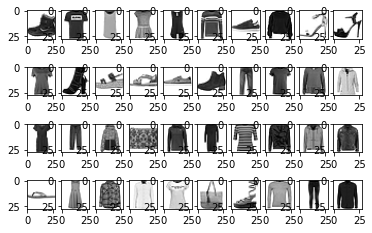

In [3]:
# Take a quick look at data 
#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
print("x_train_shape", x_train.shape)
print("x_train_type", x_train.dtype)
print("x_test_shape", x_test.shape)
# plot some raw pixel data
n_rows = 4
n_cols = 10
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row +col
        pyplot.subplot(n_rows,n_cols,index+1)
        pyplot.imshow(x_train[index], cmap="binary")

In [3]:
# Create local directory for the data and save the test and training data here

os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_test, label=y_test)

In [5]:
%%sh 
ls -l data ## Check that the directories have been created

total 53668
-rw-rw-r-- 1 ec2-user ec2-user  7850506 Sep  4 12:05 test.npz
-rw-rw-r-- 1 ec2-user ec2-user 47100506 Sep  4 12:05 training.npz


We are now going to train our model on the local instance - this is an optional step and is to check if our code will run on AWS. We train the model using TensorFlow() to create a tf_estimator object. 

In [5]:
#Import tensorflow from sagemaker
from sagemaker.tensorflow import TensorFlow

## documentation https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html

#Set environment variables - file paths to data and for output
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file:///tmp'

tf_estimator = TensorFlow(entry_point='mnist_MLP_tf2.py', #path to local python source file to be executed
                          role = role, #the IAM ROLE ARN for the model - unique user ID
                          source_dir ='.', #path to the directory where any other dependancies are apart from entry point
                          instance_count = 1, #the number of EC2 intances to use
                          instance_type ='local', # Type of EC2 instance to use local = this one! 
                          framework_version = '2.1.0', # Tensorflow version for executing your tf code
                          py_version ='py3', #version of python for executing your model training code
                          script_mode =True, #enables us to use our python script to train the model
                          hyperparameters={'epochs':1}, #hyperparameters used by our custom TensorFlow code during model training
                          output_path = output) #location for saving the results. Default = saved in the default S3 bucket.

#Note, Estimator is a high level interface for SageMaker training

In [13]:
#fit is used to train the model saved in the estimator object. We pass in file paths to the 
#trainng and test data (in this example they are stored locally)

tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

Creating 9a15vjg3g9-algo-1-zptk3 ... 
Creating 9a15vjg3g9-algo-1-zptk3 ... done
Attaching to 9a15vjg3g9-algo-1-zptk3
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:02,609 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:02,617 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:03,529 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:03,549 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:03,566 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
9a15vjg3g9-algo-1-zptk3 | 2021-09-04 12:09:03,580 sagemaker-containers INFO     Invoking user script
9a15vjg3g9-algo-1-zptk3 | 
9a15vjg3g9-algo-1-zptk3 | Training Env:
9a15vjg3g9-algo-1-zptk3 | 
9a15vjg3g9-algo-1-zptk3 | {
9a15vjg3g9-al

### D. Train the model in AWS

Now we know that our code is working on SageMaker (note, we can only do this because we have a small dataset and a shallow neural network - this wouldn't work with large datasets or deep neural networks), we can train our model on a larger instance. 

1. Upload the dataset to S3. S3 is a default bucket for storing data and model output in AWS
2. Select the [EC2 instance type](https://aws.amazon.com/ec2/instance-types/?trkCampaign=acq_paid_search_brand&sc_channel=PS&sc_campaign=acquisition_ANZ&sc_publisher=Google&sc_category=Cloud%20Computing&sc_country=ANZ&sc_geo=APAC&sc_outcome=acq&sc_detail=aws%20ec2%20instance%20pricing&sc_content={ad%20group}&sc_matchtype=e&sc_segment=489278081276&sc_medium=ACQ-P|PS-GO|Brand|Desktop|SU|Cloud%20Computing|EC2|ANZ|EN|Sitelink&s_kwcid=AL!4422!3!489278081276!e!!g!!aws%20ec2%20instance%20pricing&ef_id=Cj0KCQjw1PSDBhDbARIsAPeTqrdxZQ3nAtQNtB_MzOowvGLxppgm3YnqP08nDUrv8ubtE_Y19XwRNIcaAkaXEALw_wcB:G:s&s_kwcid=AL!4422!3!489278081276!e!!g!!aws%20ec2%20instance%20pricing) for your model. For this subject, we mainly use *ml.m4.xlarge*. EC stands for Elastic Compute Clous, and its a web service where AWS subscribers can request and provision compute services in the AWS cloud. You'll be charged per hour with different rates, depending on the instance you choose. Don't forget to terminate the instance when you're done to stop being over-charged. 

In [9]:
#Upload data to S3 bucket
## Note - we get a certain capacity for free, after that you are charged

prefix = 'keras-mnist-fashion' #first define a prefix for the key (think of this like a directory or file path)

#upload a local file/directory to S3 using upload_data(). 
##inputs = path, bucket (if not specifified will use default_bucket), optional prefix for directory structure
training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path) ### note - you can look at your buckets in the S3 section of AWS. 

s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/training/training.npz
s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/validation/test.npz


### Train with managed instances

Used [managed spot instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-spot-instances.html) to save money. 

In [10]:
from sagemaker.tensorflow import TensorFlow
tf_estimator = TensorFlow(entry_point='mnist_MLP_tf2.py',  #Python script
                          base_job_name='Mnist-MLP-example',
                          source_dir = '.',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge', # instance type
                          framework_version='2.1.0', # Tensorflow version
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 3},
                          ## after this line, everything is optional for managed spot instance
                          use_spot_instances=True,        # Use spot instance
                          max_run=3600,                    # Max training time
                          max_wait=7200,                  # Max training time + spot waiting time
                         ) 

In [11]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

2021-09-05 23:43:55 Starting - Starting the training job...
2021-09-05 23:44:18 Starting - Launching requested ML instancesProfilerReport-1630885410: InProgress
...
2021-09-05 23:44:42 Starting - Preparing the instances for training............
2021-09-05 23:46:38 Downloading - Downloading input data
2021-09-05 23:46:38 Training - Downloading the training image..2021-09-05 23:47:02,776 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-09-05 23:47:02,783 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-09-05 23:47:04,026 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-09-05 23:47:04,046 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-09-05 23:47:04,066 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-09-05 23:47:04,080 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework

### E. Deploy the model

- Model deployment means to expose the model to real use.
- This means you can make inferences or predictions using your model, 
- The model is deployed in an EC2 instance 
- Deployment is via Amazon SageMaker endpoints – an Amazon SageMaker endpoint is a fully managed service that allows you to make real-time inferences via a REST API. 



In [19]:
import time

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) #give the endpoint a name.
#used the time and date from the time library

#deploy() Deploys the Model to an Endpoint and optionally return a Predictor.
tf_predictor = tf_estimator.deploy(initial_instance_count=1, # The initial number of instances to run in the Endpoint created from this Model.
                                   instance_type='ml.t2.medium', # The EC2 instance type to deploy this Model to.
                                   endpoint_name=tf_endpoint_name) # The name of the endpoint to create     

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

### F. Prediction exercise


[[9.74125101e-07 5.06104891e-09 9.26023574e-07 3.77881156e-06
  8.89291186e-07 6.27588620e-03 1.69353797e-07 9.71421000e-01
  1.81322510e-04 2.21150685e-02]
 [3.76438180e-07 8.78118619e-11 3.81853351e-06 6.98268394e-08
  5.53618929e-06 1.12613588e-06 6.13845771e-07 8.58217553e-10
  9.99988556e-01 2.70639156e-09]
 [6.22937739e-01 5.04150055e-03 7.73639511e-03 2.27925166e-01
  1.34475911e-02 5.52464826e-06 1.22019172e-01 2.26024304e-06
  8.77442595e-04 7.18639467e-06]
 [8.59474065e-04 3.54067958e-03 3.66936505e-01 1.85424957e-04
  5.65484047e-01 5.87420850e-08 6.03521205e-02 1.15134213e-07
  2.64159474e-03 4.60491645e-09]
 [9.83833253e-01 1.25175363e-08 1.45881393e-04 1.77967340e-05
  1.00513006e-07 3.72418718e-09 1.60024688e-02 6.48734278e-12
  4.69508024e-07 1.45441781e-09]
 [4.85125092e-05 1.26844601e-09 1.12839814e-06 7.69749917e-08
  3.40819724e-07 9.99420643e-01 1.31464512e-05 4.55635956e-07
  1.65772490e-05 4.99190181e-04]
 [1.07033498e-04 9.59484623e-06 4.54528518e-02 1.33340136e

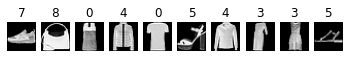

In [20]:

import random #random number generator for random sampling
import matplotlib.pyplot as plt #for plotting

#select 10 of the test samples (images) randomly
num_samples = 10
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images = x_test[indices]/255
labels = y_test[indices]

for i in range(num_samples): #plot them with their labels 
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
# Generate predictions for those random test images
# Apply the preductor() function to a Predictor oject
# It returns inferences for the given input - in this case the images

prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction) #save the predictions as a np.array (softmax decimal probabilties)
print(prediction)
predicted_labels = prediction.argmax(axis=1) #use argmax to turn the predictions into class labels
print('Predicted labels are: {}'.format(predicted_labels)) # print out the labels

### Delete the endpoint

Remember to delete the endpoint when you are not using to avoid unnecessary surcharge from AWS.

In [21]:
tf_predictor.delete_endpoint()

### Shutdown the notebook instances

In [ ]:
import boto3
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.stop_notebook_instance(
        NotebookInstanceName='MA3832-Prac7')